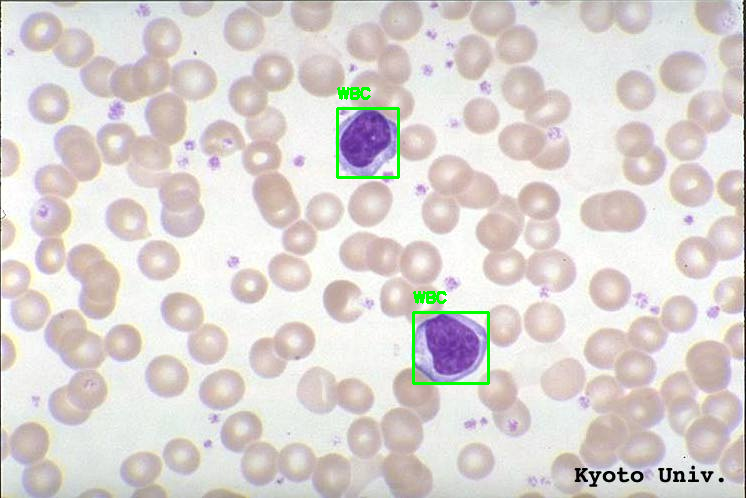

Number of Violet White Blood Cells (WBC): 2
Filenames of saved images: ['/content/cropped_wbc_1.jpeg', '/content/cropped_wbc_2.jpeg']


In [8]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # Import cv2_imshow for displaying images in Colab

# Read the enhanced image
img = cv2.imread('/content/WBC3.jpeg')

# Convert the image to HSV color space
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define the range of violet color in HSV
lower_violet = np.array([120, 50, 50])
upper_violet = np.array([150, 255, 255])

# Create a mask to extract violet color
mask = cv2.inRange(hsv, lower_violet, upper_violet)

# Bitwise AND operation to get the violet regions
result = cv2.bitwise_and(img, img, mask=mask)

# Convert the result to grayscale
gray_result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

# Apply morphological operations
kernel = np.ones((5, 5), np.uint8)
closing = cv2.morphologyEx(gray_result, cv2.MORPH_CLOSE, kernel)

# Find contours in the image
contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize the list
cropped_images = []

# Loop over the contours
for i, contour in enumerate(contours):
    # Get the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Calculate circularity if contour length is non-zero
    if cv2.arcLength(contour, True) != 0:
        circularity = 4 * np.pi * cv2.contourArea(contour) / (cv2.arcLength(contour, True) ** 2)
    else:
        circularity = 0

    # Set size and circularity thresholds to filter out unwanted contours
    size_threshold = 500
    circularity_threshold = 0.5

    if cv2.contourArea(contour) > size_threshold and circularity > circularity_threshold:
        # Crop the region of interest (ROI) from the original image
        wbc_roi = img[y:y + h, x:x + w]

        # Append the cropped image to the list
        cropped_images.append(wbc_roi)

        # Draw a rectangle around the detected cell
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Add label to the rectangle
        cv2.putText(img, 'WBC', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the result using cv2_imshow
cv2_imshow(img)

# Display the count of detected white blood cells
print("Number of Violet White Blood Cells (WBC):", len(cropped_images))

# Save cropped images as new JPEG files in an array
saved_images = []
for i, cropped_img in enumerate(cropped_images):
    filename = f'/content/cropped_wbc_{i+1}.jpeg'
    saved_images.append(filename)
    cv2.imwrite(filename, cropped_img)

# Print the filenames of saved images
print("Filenames of saved images:", saved_images)


1/1 [==============================] - 1s 799ms/step
Segmented Image 1 - Predicted WBC Type: Lymphocyte


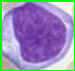

1/1 [==============================] - 0s 21ms/step
Segmented Image 2 - Predicted WBC Type: Lymphocyte


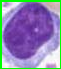

Total WBC Counts:
Neutrophil: 0
Lymphocyte: 2
Monocyte: 0
Eosinophil: 0
Basophil: 0


In [9]:
import numpy as np
import cv2
from keras.models import load_model
from google.colab.patches import cv2_imshow  # Import cv2_imshow for displaying images in Colab

# Load the pre-trained model
model = load_model('/content/blood_cell_classifier.h5')  # Replace with the actual path to your .h5 model file

# Read the enhanced image
img = cv2.imread('/content/WBC3.jpeg')

# ... (Previous code for segmentation)

# Initialize a dictionary to store counts for each WBC type
wbc_counts = {'Neutrophil': 0, 'Lymphocyte': 0, 'Monocyte': 0, 'Eosinophil': 0, 'Basophil': 0}

# Loop over the cropped images
for i, cropped_img in enumerate(cropped_images):
    # Resize the image to match the input size expected by the model
    resized_img = cv2.resize(cropped_img, (224, 224))  # Adjust the size according to your model input size

    # Preprocess the image for the model
    preprocessed_img = resized_img / 255.0  # Normalize pixel values to the range [0, 1]
    preprocessed_img = np.expand_dims(preprocessed_img, axis=0)  # Add batch dimension

    # Perform classification using the loaded model
    predictions = model.predict(preprocessed_img)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions)

    # Map class index to WBC type
    wbc_types = ['Neutrophil','Lymphocyte', 'Monocyte','Eosinophil', 'Basophil']
    predicted_wbc_type = wbc_types[predicted_class_index]

    # Update the count in the dictionary
    wbc_counts[predicted_wbc_type] += 1

    # Display the segmented image and its predicted WBC type
    print(f"Segmented Image {i+1} - Predicted WBC Type: {predicted_wbc_type}")
    cv2_imshow(cropped_img)

# Display the total count of each WBC type
print("Total WBC Counts:")
for wbc_type, count in wbc_counts.items():
    print(f"{wbc_type}: {count}")
